# 回折計算

このnotebookでは以下の4種類の回折計算の方法を試しています。

* フラウンホーファー回折
* フレネル回折
* 角スペクトル法
* フレネル・キルヒホッフの回折式の数値積分

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

変数を定義していきます。

In [22]:
l = 0.941e-6 #波長
k = 2 * np.pi / l #波数
zq = 10e-3 # 10mm
N = 192 #グリッド数
r = 0.5e-3 #半径
D = 0.01 #開口面上の計算領域の１辺の長さ
fscale = l*zq

開口面上の複素振幅を定義します。ここでは単純な円形開口を考え、開口面上で1となるように複素振幅を与えます。

In [23]:
def P(x, y):
    if x**2 + y**2 < r**2:
        return 1
    else:
        return 0

開口面上に計算領域となるグリッドX, Yを生成し、開口面上の複素振幅をZに格納します。

In [24]:
X, Y = np.meshgrid(np.linspace(-D/2, D/2, num=N), np.linspace(-D/2, D/2, num=N))
Pv = np.vectorize(P)
Z = Pv(X, Y)

Zをプロットして確認します。

Text(0, 0.5, '$y_p$ [m]')

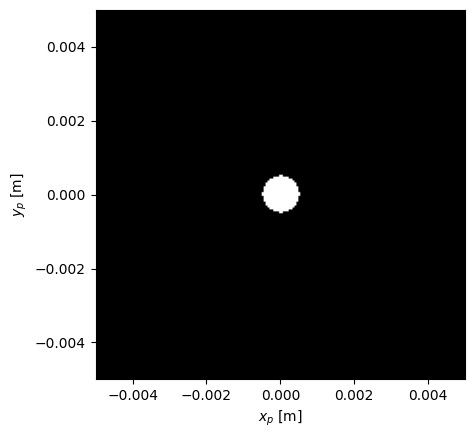

In [25]:
plt.imshow(Z, extent=[-D/2, D/2, -D/2, D/2], cmap='gray')
plt.xlabel('$x_p$ [m]')
plt.ylabel('$y_p$ [m]')

角スペクトル法で回折を計算します

In [26]:
# 角スペクトル法
U = np.fft.fft2(Z)
k_x = np.fft.fftfreq(N, d=D/N) * 2 * np.pi
k_y = np.fft.fftfreq(N, d=D/N) * 2 * np.pi
K_X, K_Y = np.meshgrid(k_x, k_y)
k_z = np.sqrt(k**2 - K_X**2 - K_Y**2)
# 角スペクトル法で計算した像面上の複素振幅
U_angular = np.fft.ifft2(U * np.exp(1.0j * k_z * zq))

# 強度を計算
I_angular = np.abs(U_angular)**2
# 正規化
I_angular = I_angular / np.max(I_angular)

結果をプロットしてみます

Text(0.5, 1.0, 'Angular Spectrum Diffraction')

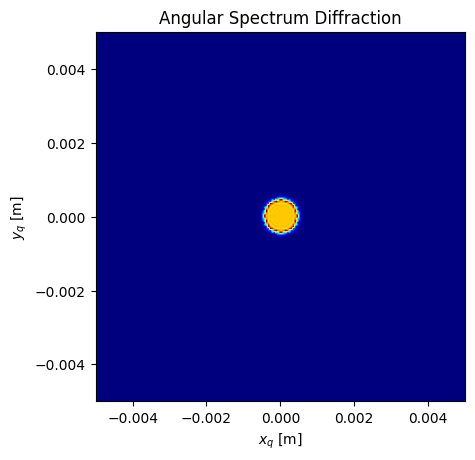

In [27]:
plt.imshow(I_angular, cmap='jet', extent=[-D/2, D/2, -D/2, D/2])
plt.xlabel('$x_q$ [m]')
plt.ylabel('$y_q$ [m]')
plt.title('Angular Spectrum Diffraction')

次にフレネル近似・フラウンホーファー近似で回折を計算していきます

これらの方法はフーリエ変換によって像面上の複素振幅を計算するので、像面上の計算領域が開口面上の計算領域と異なるものになります。

そこで最初に対応する像面上の計算領域を求めておきます。

In [28]:
v = np.fft.fftfreq(N, d=D/N)
v = fscale * np.fft.fftshift(v)
extent= [1e3 * v[0], 1e3 * v[-1], 1e3 * v[0], 1e3 * v[-1]] # 単位は[mm]

フレネル近似で回折を計算します。

まずは近似の条件を確認します。

In [29]:
# フレネル近似の条件
(np.pi / l * (r + 1e-3*(extent[1] - extent[0])/2)**4)**(1/3)

0.0073936248527348945

FFTを用いてフレネル回折を計算します。

In [30]:
# フレネル回折
U_fresnel = np.fft.fft2(Z * np.exp(1.0j * k * (X**2 + Y**2)/(2*zq)))
U_fresnel = 1/(1.0j * l * zq) * np.exp(1.0j * k * zq) * np.exp(1.0j * k * (v**2 + v**2)/(2*zq)) * np.fft.fftshift(U_fresnel)

# 強度
I_fresnel = np.abs(U_fresnel)**2
# 正規化
I_fresnel = I_fresnel / np.max(I_fresnel)

強度をプロットしてみます。

Text(0.5, 1.0, 'Fresnel Diffraction')

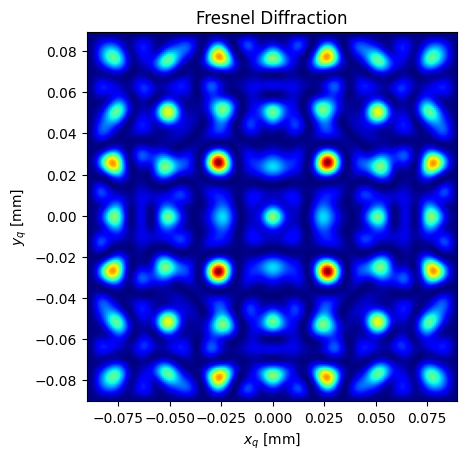

In [31]:
plt.imshow(I_fresnel, cmap='jet', extent=extent)
plt.xlabel('$x_q$ [mm]')
plt.ylabel('$y_q$ [mm]')
plt.title('Fresnel Diffraction')

次にフラウンホーファー近似で回折を計算してみます。

まずは近似の条件を確認します。

In [32]:
# フラウンホーファー近似の条件
np.pi / l * r**2

0.8346420439930375

FFTを用いてフラウンホーファー回折を計算します。

In [33]:
# フラウンホーファー回折
U_fraun = np.fft.fft2(Z)
U_fraun = 1/(1.0j * l * zq) * np.exp(1.0j * k * zq) * np.exp(1.0j * k * (v**2 + v**2)/(2*zq)) * np.fft.fftshift(U_fraun)

# 強度
I_fraun = np.abs(U_fraun)**2
# 正規化
I_fraun = I_fraun / np.max(I_fraun)

強度をプロットしてみます。

Text(0.5, 1.0, 'Fraunhofer Diffraction')

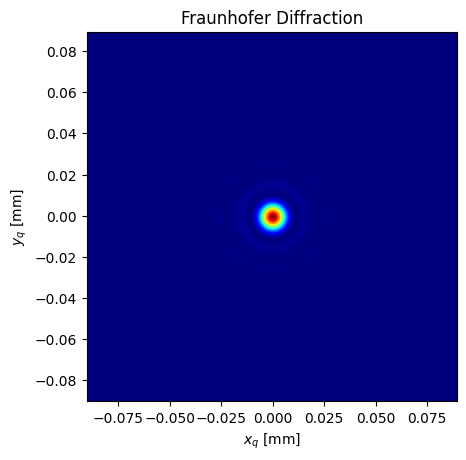

In [34]:
plt.imshow(I_fraun, cmap='jet', extent=extent)
plt.xlabel('$x_q$ [mm]')
plt.ylabel('$y_q$ [mm]')
plt.title('Fraunhofer Diffraction')

理論的なエアリーディスクの半径を確認します。

In [35]:
# エアリーディスクの半径
1.22 * l/(2*r) * zq

1.14802e-05

最後にフレネル・キルヒホッフの回折式を直接数値積分することで回折を計算してみます。

In [36]:
# フレネル・キルヒホッフの回折式
def Uf(x_q, y_q):
    r = np.sqrt((x_q - X)**2 + (y_q - Y)**2 + zq**2)
    return zq/(1.0j * l) * (Z * np.exp(1.0j * k * r) / r**2).sum()

X_Q, Y_Q = np.meshgrid(np.linspace(extent[0]*1e-3, extent[1]*1e-3, num=N), np.linspace(extent[2]*1e-3, extent[3]*1e-3, num=N))
U_strict = np.vectorize(Uf)(X_Q, Y_Q)
I_strict = np.abs(U_strict)**2
I_strict = I_strict / np.max(I_strict)

強度をプロットしてみます。

Text(0.5, 1.0, 'Fresnel Kirchhoff Diffraction')

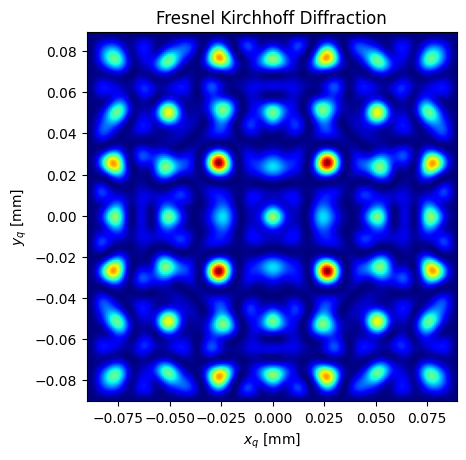

In [37]:
plt.imshow(I_strict, cmap='jet', extent=extent)
plt.xlabel('$x_q$ [mm]')
plt.ylabel('$y_q$ [mm]')
plt.title('Fresnel Kirchhoff Diffraction')

フレネル近似とフラウンホーファー近似の強度の二乗誤差を見てみます。

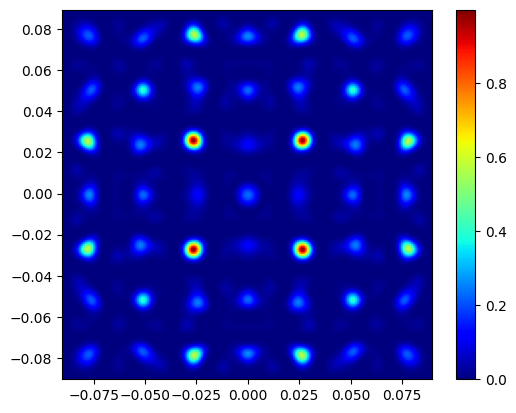

In [38]:
# フレネル近似とフラウンホーファー近似の二乗誤差
plt.imshow((I_fresnel - I_fraun)**2, cmap='jet', extent=extent)
plt.colorbar()

フレネル・キルヒホッフの回折式を数値積分したものと、フレネル近似の強度の二乗誤差を見てみます。

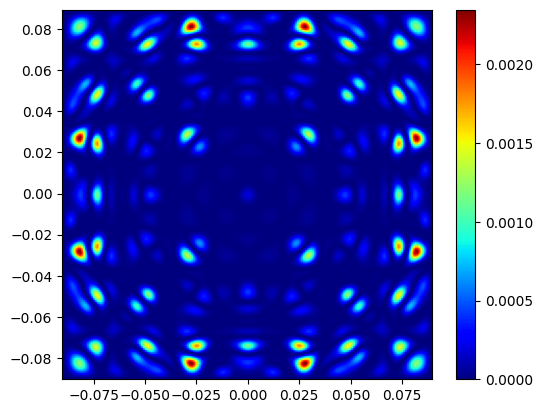

In [39]:
# 厳密解とフレネル近似の二乗誤差
plt.imshow((I_strict - I_fresnel)**2, cmap='jet', extent=extent)
plt.colorbar()

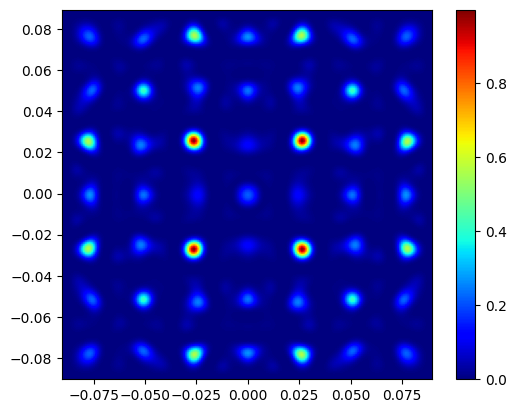

In [40]:
# 厳密解とフラウンホーファー近似の二乗誤差
plt.imshow((I_strict - I_fraun)**2, cmap='jet', extent=extent)
plt.colorbar()